In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
from datetime import datetime

import json
import pickle

# Our generated code
import os
import sys
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)
    
%load_ext autoreload
%autoreload 2
    
from libs import exploring as explore
from libs import visualising as visualize
from libs import cleansing as cleanse

PLOT = True
RUN = False

In [3]:
# Import data
open_food_facts_csv_file = "./data/en.openfoodfacts.org.products.csv"

# Load list of columns (external file) that are loaded into pyspark
data = []
with open("./data/cleanse/columns_to_import.txt", "r") as json_data:
    columns_to_import = json.load(json_data)
    columns_to_import


food_facts_pd = pd.read_csv(open_food_facts_csv_file,
                            delimiter="\t",
                            usecols=columns_to_import.keys(),
                            dtype=columns_to_import)

FileNotFoundError: File b'./data/en.openfoodfacts.org.products.csv' does not exist

In [3]:
data_summary_string = "The dataset now comprises {} entries, of which we have {} features."
data_summary_string.format(food_facts_pd.shape[0], food_facts_pd.shape[1])

'The dataset now comprises 691256 entries, of which we have 22 features.'

# Explore the data
We begin with taking a quick look on the raw data.

In [4]:
food_facts_pd.head(5)

,code,created_t,created_datetime,product_name,quantity,packaging,brands,categories_en,origins,origins_tags,...,labels_en,purchase_places,stores,countries_en,ingredients_text,main_category,energy_100g,carbon-footprint_100g,nutrition-score-fr_100g,nutrition-score-uk_100g
0,0000000000017,1529059080,2018-06-15T10:38:00Z,Vitória crackers,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,France,NaN,NaN,1569.0,NaN,NaN,NaN
1,0000000000031,1539464774,2018-10-13T21:06:14Z,Cacao,130 g,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,France,NaN,NaN,NaN,NaN,NaN,NaN
2,0000000000123,1535737982,2018-08-31T17:53:02Z,Sauce Sweety chili 0%,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,France,NaN,NaN,88.0,NaN,NaN,NaN
3,0000000000291,1534239669,2018-08-14T09:41:09Z,Mendiants,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,France,NaN,NaN,NaN,NaN,NaN,NaN
4,0000000000949,1523440813,2018-04-11T10:00:13Z,Salade de carottes râpées,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,France,NaN,NaN,134.0,NaN,NaN,NaN


## Display number of non-NaN entries per column

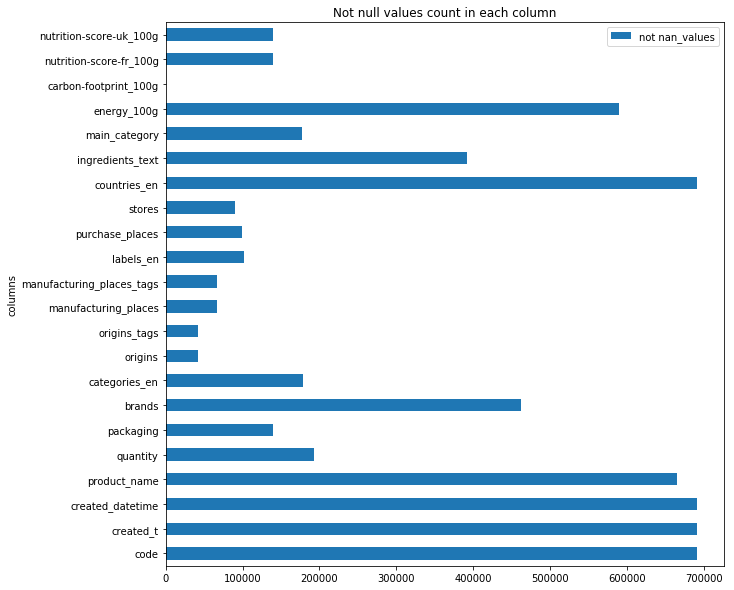

In [5]:
null_entries = pd.DataFrame({'columns' : food_facts_pd.columns,
                             'not nan_values' : [food_facts_pd[c].count() for c in food_facts_pd]
                            })

# Plot NaNs counts
if PLOT:
    null_entries.set_index('columns').plot(kind='barh', figsize=(10, 10))
    plt.title("Not null values count in each column")
    plt.show()

We see that there are many NaN entries in this data set. For our analysis, we can only use entries that have at least a product name, country tag, manufacturing and purchase place, store, and a created date tag. Unfortunately, we have to drop all columns, that lack these entries.

In [6]:
no_rows_inital = food_facts_pd.shape[0]

# Drop entries with missing entries in one of our main-features
essential_columns = ['created_t', 
                     'product_name', 
                     'countries_en', 
                     'categories_en', 
                     'stores',
                     'manufacturing_places', 
                     'purchase_places']

food_facts_pd = food_facts_pd.dropna(subset=essential_columns, )

no_rows_reduced_nan = food_facts_pd.shape[0]

# Also drop duplicated values (indentify based on index (barcode))
food_facts_pd = food_facts_pd.drop_duplicates()

no_rows_reduced_duplicates = food_facts_pd.shape[0]

print("{} entries were dropped, {} of those were duplicates."\
      .format(no_rows_inital-no_rows_reduced_duplicates, 
              no_rows_reduced_nan-no_rows_reduced_duplicates)
     )
print(data_summary_string.format(food_facts_pd.shape[0], 
                                 food_facts_pd.shape[1]))

650317 entries were dropped, 1 of those were duplicates.
The dataset now comprises 40939 entries, of which we have 22 features.


Puhh, that was though. From now on, we are going to rescue the data and enrich wherever we can.

In [7]:
# Replace NaNs with emptry string
food_facts_pd = food_facts_pd.fillna("")

In [8]:
# Next lets look at the data types:

In [9]:
food_facts_pd.dtypes

code                         object
created_t                    object
created_datetime             object
product_name                 object
quantity                     object
packaging                    object
brands                       object
categories_en                object
origins                      object
origins_tags                 object
manufacturing_places         object
manufacturing_places_tags    object
labels_en                    object
purchase_places              object
stores                       object
countries_en                 object
ingredients_text             object
main_category                object
energy_100g                  object
carbon-footprint_100g        object
nutrition-score-fr_100g      object
nutrition-score-uk_100g      object
dtype: object

Another thing that we are not really keen of are the language indicators, so we are going to remove those abbreviations.

In [10]:
def remove_language_indicator(row_str):
    tags = [tag if len(tag.split(':'))==1 else tag.split(':')[1] for tag in row_str.split(',')]
    return ",".join(tags)

In [11]:
food_facts_pd.categories_en = food_facts_pd.categories_en.apply(remove_language_indicator)
food_facts_pd.main_category = food_facts_pd.main_category.apply(remove_language_indicator)
food_facts_pd.countries_en = food_facts_pd.countries_en.apply(remove_language_indicator)
food_facts_pd.labels_en = food_facts_pd.labels_en.apply(remove_language_indicator)

# Cleanse data

## Unitize tags
Many parts of the data are categorizations based on tags. However, those tags are in a variety of languages and string formattings, so in order to use them we attempt to group tags that hint to the same property and map them to a common indicator. 

Every column of the data set requires special treatment, as follows:

### Countries tags

Note :  
- purchase_places and countries_en are the same though "countries_en" has more entries
- manufacturing_places and origins are different

"_Countries_" is a csv file modified in the "_Country__names.ipynb_" file from the source (available at https://mledoze.github.io/countries/). We need to harmonise country names (and push them to English since many entries use French and German). The columns requiring our attentions are the following:
- origins
- manufacturing_places
- countries_en

Note that each have a respective redundant column : origins_tags, manufacturing_places_tags and purchase_places. We are going to filter these by a function in our _cleansing.py_ library to lead to the following respective columns:
- origins_cleaned
- manufacturing_place_cleaned
- purchase_places_cleaned

In [12]:
food_facts_pd['origins_cleaned'] = food_facts_pd.origins
food_facts_pd['manufacturing_place_cleaned'] = food_facts_pd.manufacturing_places
food_facts_pd['purchase_places_cleaned'] = food_facts_pd.countries_en

In [13]:
# Load analyse file
countries = pd.read_csv("./data/country_lookup.csv")[['name', 'cca2', 'alias', 'Forced']]

The following is a test to see how complete the harmonisation is

Now let's attack the Open Food Fact database

In [14]:
#The following commands should not be run except if the analysis has to be performed again. 
#Access the result in ./data/food_facts_pd_countries_names.csv (will be saved to that)
######################################################

In [15]:
if( RUN ):
    food_facts_pd.origins_cleaned = food_facts_pd.origins_cleaned\
        .apply(lambda x: cleanse.country_name_filter(x, countries))

In [16]:
if( RUN ):
    food_facts_pd.manufacturing_place_cleaned = food_facts_pd.manufacturing_place_cleaned\
        .apply(lambda x: cleanse.country_name_filter(x, countries))

In [17]:
if( RUN ):
    food_facts_pd.purchase_places_cleaned = food_facts_pd.purchase_places_cleaned\
        .apply(lambda x: cleanse.country_name_filter(x, countries))

In [18]:
#Let's save these columns so that we don't have to run them again. 

#Do not run this command if you have not processed the whole dataset !
if( RUN ):
    food_facts_pd_countries_names = food_facts_pd[['origins_cleaned', 
                                                   'manufacturing_place_cleaned', 
                                                   'purchase_places_cleaned']
                                                 ]
    food_facts_pd_countries_names.to_csv("./data/food_facts_pd_countries_names.csv")

In [19]:
######################################################

### Labels tags

In [20]:
# Unitze labels
with open('./data/cleanse/taxonomies.json', 'r') as json_data:
    labels_lookup = cleanse.to_lookup(json.load(json_data))
food_facts_pd.labels_en = food_facts_pd.labels_en.\
    apply(lambda x: [labels_lookup[z] for z in x.split(',')])

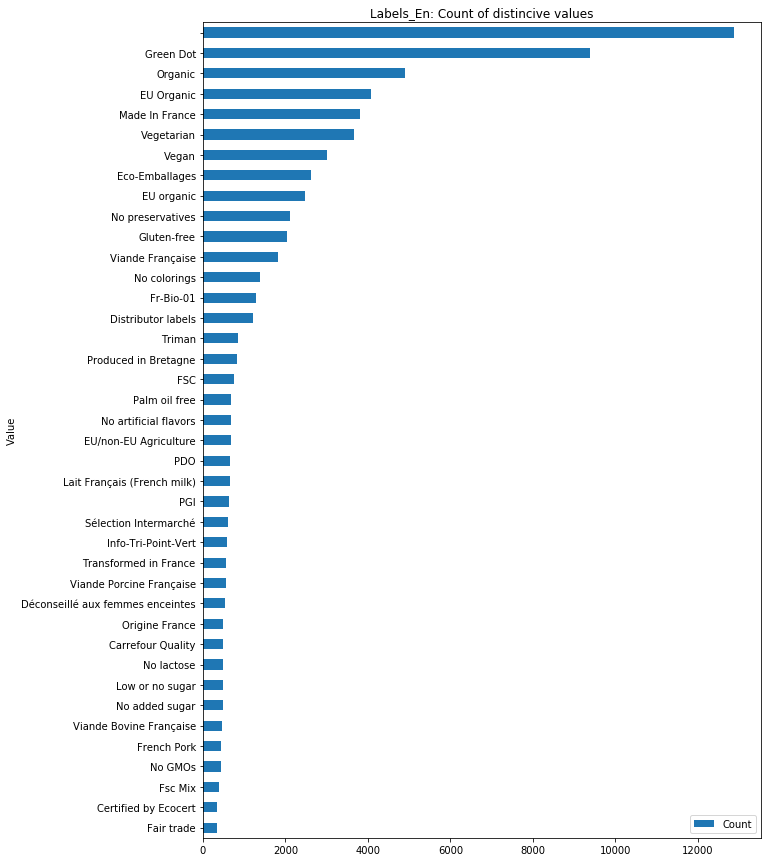

In [21]:
if PLOT:
    _,_ = visualize.plot_occurences_of_distinct_values(food_facts_pd, 'labels_en')

### Store labels tags

In [22]:
# Unitize store labels
with open('./data/cleanse/stores_lookup.json', 'r') as json_data:
    stores_lookup = cleanse.to_lookup(json.load(json_data))
food_facts_pd.stores = food_facts_pd.stores.fillna("")\
    .apply(lambda x: [stores_lookup[z] for z in x.split(',')])

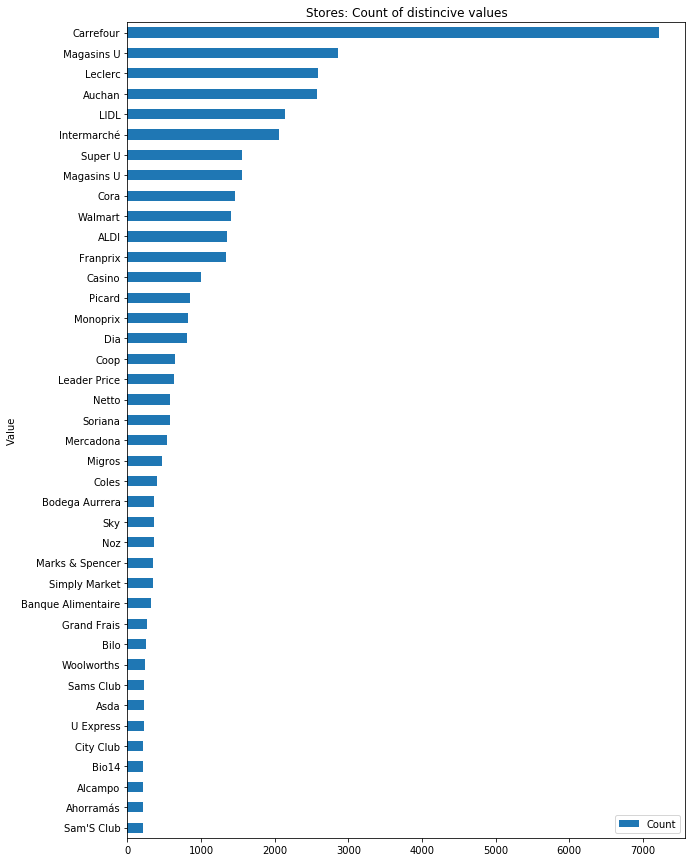

In [23]:
if PLOT:
    _,_ = visualize.plot_occurences_of_distinct_values(food_facts_pd, 'stores')

### Food category tags

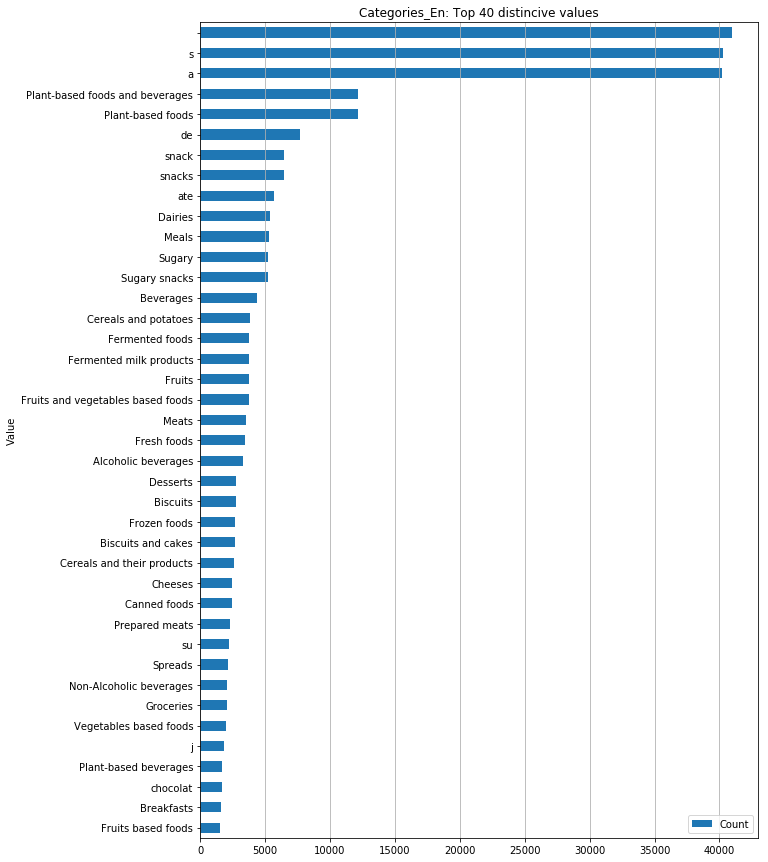

In [24]:
if PLOT:
    _,_ = visualize.plot_occurences_of_distinct_values_from_strings(food_facts_pd, 'categories_en')

## Carbon footprint dataset

Because the food facts database lacks carbon footprint specifications, we got random samples of products from Eaternity database. Unfortunately, we were not allowed access to the API before purchasing a 2000 CHF license. However, this weekend, we were given a dataset of carbon footprints for specific products. To use it for our analysis, we have to categorize this products, as they do not match with the food items in the food facts database.

Let's still take a quick look at the Carbon Footprint database, that we have obtained.

### Loading the data

In [4]:
# Import data
carbon_footprint_csv_file = "./data/carbon_footprint.csv"

carbon_footprint_pd = pd.read_csv(carbon_footprint_csv_file, delimiter=",")

#Import data with categories 
# Import data
carbon_footprint_categories_csv_file = "./data/carbon_footprint_categories.csv"

carbon_footprint_categories_pd = pd.read_csv(carbon_footprint_categories_csv_file)


In [5]:
print('We have {0} ecological features for {1} products.'\
      .format(carbon_footprint_pd.shape[1], 
              carbon_footprint_pd.shape[0]))

We have 9 ecological features for 692 products.


We are interested in the carbon footprint of each product. Because our sample is small (around 700 products) and doesn't really match with the Food Facts Database, we will take care of the categories. Thus, we will extract the categories from [Codecheck website](https://www.codecheck.info/) (Webscraper).

Text(0.5,1,'Distribution of the carbon ')

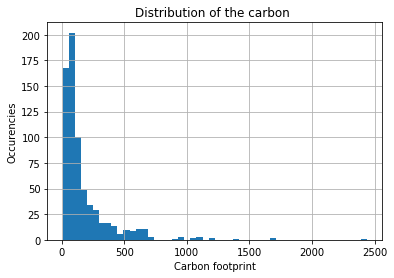

In [6]:
ax = carbon_footprint_pd['CO2-Value [gram CO2/serving]'].hist(bins=50)
ax.set_xlabel('Carbon footprint')
ax.set_ylabel('Occurencies')
ax.set_title('Distribution of the carbon ')

In [11]:
#translation of category column
translated_column = cleanse.translate_columns(carbon_footprint_categories_pd['category'])


In [12]:
translated_column

['MYMEMORY WARNING: YOU USED ALL AVAILABLE FREE TRANSLATIONS FOR TODAY. NEXT AVAILABLE IN  15 HOURS 03 MINUTES 45 SECONDSVISIT HTTPS://MYMEMORY.TRANSLATED.NET/DOC/USAGELIMITS.PHP TO TRANSLATE MORE',
 'MYMEMORY WARNING: YOU USED ALL AVAILABLE FREE TRANSLATIONS FOR TODAY. NEXT AVAILABLE IN  15 HOURS 03 MINUTES 45 SECONDSVISIT HTTPS://MYMEMORY.TRANSLATED.NET/DOC/USAGELIMITS.PHP TO TRANSLATE MORE',
 'MYMEMORY WARNING: YOU USED ALL AVAILABLE FREE TRANSLATIONS FOR TODAY. NEXT AVAILABLE IN  15 HOURS 03 MINUTES 45 SECONDSVISIT HTTPS://MYMEMORY.TRANSLATED.NET/DOC/USAGELIMITS.PHP TO TRANSLATE MORE',
 'MYMEMORY WARNING: YOU USED ALL AVAILABLE FREE TRANSLATIONS FOR TODAY. NEXT AVAILABLE IN  15 HOURS 03 MINUTES 45 SECONDSVISIT HTTPS://MYMEMORY.TRANSLATED.NET/DOC/USAGELIMITS.PHP TO TRANSLATE MORE',
 'MYMEMORY WARNING: YOU USED ALL AVAILABLE FREE TRANSLATIONS FOR TODAY. NEXT AVAILABLE IN  15 HOURS 03 MINUTES 45 SECONDSVISIT HTTPS://MYMEMORY.TRANSLATED.NET/DOC/USAGELIMITS.PHP TO TRANSLATE MORE',
 'MYM

## Concat price info

We also searched online shops for price information about some of the products, that we are going to merge in the following.

In [28]:
prices = pd.read_csv("./web_crawler/data/prices_carbon.csv", dtype={'code':object})

In [29]:
prices_reduced = prices[['product_name', 'price_per_100g', 'store_currency']]

Because the OpenFoodFacts code is not necessarily a global barcode for the product, we had to match the products from the online stores and the entries of the database by teh product name. To be consistent with that method, we merge the prices by the product name.

In [30]:
food_facts_pd = pd.merge(food_facts_pd, prices_reduced, on='product_name', how='left')

In [31]:
print("Product prices successfully merged: {}".format(food_facts_pd.price_per_100g.count()))

Product prices successfully merged: 173


## Remove negative entries
We have few numerical features, which are the calories (energy), carbon-footprint, and price per 100g of the product. These values are due to physical or economic laws non-negative, which we are going to ensure in the following.

In [32]:
numeric_columns = food_facts_pd.select_dtypes(include=['int16', 'int32', 'int64', 'float16', 'float32', 'float64']).columns

food_facts_pd[numeric_columns] = food_facts_pd[numeric_columns].where(food_facts_pd[numeric_columns] >= 0, np.NaN)

# Write clean data frame to CSV file

In [33]:
# Generate a dataframe that extracts all information required by the web crawler
if 1==0: # skip cell
    products = food_facts_pd[['code', 
                              'product_name', 
                              'stores', 
                              'carbon-footprint_100g', 
                              'nutrition-score-fr_100g']
                            ]
    products = products[products['carbon-footprint_100g']!=""]

    products.to_pickle("./web_crawler/data/products_pd.pickle")

Note : country names harmonised are available in ./data/food_facts_pd_countries_names.csv (note the additional code to go back to a list of strings). 

In [34]:
# Apply country name filter

countries_names= pd.read_csv("./data/food_facts_pd_countries_names.csv")
countries_names.origins_cleaned = \
                        countries_names.origins_cleaned.apply(lambda l: cleanse.read(l))

countries_names.manufacturing_place_cleaned = \
                        countries_names.manufacturing_place_cleaned.apply(lambda l: cleanse.read(l))

countries_names.purchase_places_cleaned = \
                        countries_names.purchase_places_cleaned.apply(lambda l: cleanse.read(l))

food_facts_pd = food_facts_pd.drop(['origins', 
                                    'manufacturing_places', 
                                    'countries_en',
                                   'origins_tags', 
                                    'manufacturing_places_tags',
                                    'purchase_places'], \
                                    axis=1)

food_facts_pd['origins_cleaned'] = countries_names.origins_cleaned
food_facts_pd['manufacturing_place_cleaned'] = countries_names.manufacturing_place_cleaned
food_facts_pd['purchase_places_cleaned'] = countries_names.purchase_places_cleaned
food_facts_pd.head(2)

,code,created_t,created_datetime,product_name,quantity,packaging,brands,categories_en,labels_en,stores,...,main_category,energy_100g,carbon-footprint_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,origins_cleaned,manufacturing_place_cleaned,purchase_places_cleaned,price_per_100g,store_currency
0,0000000274722,1514659309,2017-12-30T18:41:49Z,Blanquette de Volaille et son Riz,,"carton,plastique",Comme J’aime,"Meals,Meat-based products,Meals with meat,Poul...","[Viande Française, Made In France]",[Comme J'Aime],...,meals,450,,0,0,[Unknown],[France],[France],NaN,NaN
1,0000000394710,1484497370,2017-01-15T16:22:50Z,Danoises à la cannelle roulées,1.150 kg,Frais,Kirkland Signature,"Sugary snacks,Biscuits and cakes,Pastries",[],[Costco],...,sugary-snacks,1520,,,,[France],[France],[France],NaN,NaN


In [35]:
food_facts_pd.origins_cleaned.isnull().any().any()

False

In [36]:
food_facts_pd.origins_cleaned= food_facts_pd.origins_cleaned.fillna("['Unknown']")
food_facts_pd.manufacturing_place_cleaned= food_facts_pd.manufacturing_place_cleaned.fillna("['Unknown']")
food_facts_pd.purchase_places_cleaned= food_facts_pd.purchase_places_cleaned.fillna("['Unknown']")

In [37]:
food_facts_pd.origins_cleaned.isnull().any().any()

False

In [38]:
# Write to CSV file
clean_data_file_name = "./data/openfoodfacts_clean.csv"
food_facts_pd.to_csv(clean_data_file_name, sep='\t', encoding='utf-8')

In [39]:
food_facts_pd

,code,created_t,created_datetime,product_name,quantity,packaging,brands,categories_en,labels_en,stores,...,main_category,energy_100g,carbon-footprint_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,origins_cleaned,manufacturing_place_cleaned,purchase_places_cleaned,price_per_100g,store_currency
0,0000000274722,1514659309,2017-12-30T18:41:49Z,Blanquette de Volaille et son Riz,,"carton,plastique",Comme J’aime,"Meals,Meat-based products,Meals with meat,Poul...","[Viande Française, Made In France]",[Comme J'Aime],...,meals,450,,0,0,[Unknown],[France],[France],NaN,NaN
1,0000000394710,1484497370,2017-01-15T16:22:50Z,Danoises à la cannelle roulées,1.150 kg,Frais,Kirkland Signature,"Sugary snacks,Biscuits and cakes,Pastries",[],[Costco],...,sugary-snacks,1520,,,,[France],[France],[France],NaN,NaN
2,0000001071894,1409411252,2014-08-30T15:07:32Z,Flute,,"Paper,plastic film",Waitrose,"Plant-based foods and beverages,Plant-based fo...",[],[Waitrose],...,plant-based-foods-and-beverages,,,,,[Canada],[Unknown],[Canada],NaN,NaN
3,0000001938067,1484501528,2017-01-15T17:32:08Z,Chaussons tressés aux pommes,1.200 kg,Frais,Kirkland Signature,"Sugary snacks,Biscuits and cakes,Pastries",[],[Costco],...,sugary-snacks,1090,,9,9,[France],[United Kingdom],[United Kingdom],NaN,NaN
4,0000004302544,1488464896,2017-03-02T14:28:16Z,Pain Burger Artisan,1.008 kg / 12 pain,"Frais,plastique",Kirkland Signature,boulange,[],[Costco],...,boulange,1160,,1,1,[Canada],[Unknown],[Canada],NaN,NaN
5,0000008237798,1491943307,2017-04-11T20:41:47Z,Quiche Lorraine,1 400 kg,Frai,Kirkland Signature,"Meals,Pizzas pies and quiches,Quiches,Lorraine...",[],[Costco],...,meals,478,,2,2,[Canada],[Canada],[Canada],NaN,NaN
6,0000008240095,1484342673,2017-01-13T21:24:33Z,Pâté au poulet,1250 kg,Frais,Kirkland Signature,"Meats,Poultries,Chickens,Cooked chicken",[],[Costco],...,meats,751,,,,[Unknown],[United States],"[France, United States]",NaN,NaN
7,0000010090206,1370977431,2013-06-11T19:03:51Z,Thé de Noël aromatisé orange-cannelle,75 g,aluminium,Alice Délice,"Plant-based foods and beverages,Beverages,Plan...",[],[Alice Délice],...,beverages,,,,,[Unknown],[France],[France],NaN,NaN
8,0000012167005,1523553417,2018-04-12T17:16:57Z,Brioches roulées avec raisins,0.900 kg,En caissette,Kirkland Signature,"Sugary snacks,Biscuits and cakes,Pastries",[],[Costco],...,sugary-snacks,536,,0,0,[Canada],[Canada],[Canada],NaN,NaN
9,0000027533024,1418732959,2014-12-16T12:29:19Z,Luxury Christmas Pudding,454g,"plastic,bowl","Asda,Asda Extra Special","Desserts,Puddings,Christmas Puddings",[],[Asda],...,desserts,1284,,11,11,[Canada],[Unknown],[Canada],NaN,NaN
